In [1]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
import matplotlib.pyplot as plt 
import numpy as np 
from qiskit.quantum_info import Statevector, random_clifford 

In [2]:
from tomography import SelfGuidedTomography, Mean_Direct_Fidelity

In [3]:
NQ = 2
MDF = Mean_Direct_Fidelity(NQ)
state = np.random.randn( 2**NQ )
state = state / np.linalg.norm( state )

In [4]:
Omega = random_clifford( NQ ).to_circuit()
state = np.array( Statevector(Omega) )
state

array([-0.5+0.j ,  0. +0.5j,  0. +0.5j, -0.5+0.j ])

In [5]:
MDF.Chi( state, None ).round(2)

array([ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,
        0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.5+0.j,
        0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j])

In [6]:
alpha = 0 #1 / 2**NQ
MDF.Chi( state, truncation=alpha ).round(2)

array([ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,
        0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.5+0.j,
        0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j])

In [7]:
np.outer( state, state.conj() ).round(2)

array([[0.25+0.j  , 0.  +0.25j, 0.  +0.25j, 0.25+0.j  ],
       [0.  -0.25j, 0.25+0.j  , 0.25+0.j  , 0.  -0.25j],
       [0.  -0.25j, 0.25+0.j  , 0.25+0.j  , 0.  -0.25j],
       [0.25+0.j  , 0.  +0.25j, 0.  +0.25j, 0.25+0.j  ]])

### Initial Parameters

In [8]:
NQs = [2,3,4,5,6]
L = len(NQs)
N = 10
shots = 1000
simulator_ideal=Estimator(backend_options={'shots':shots,
                                            'method':"stabilizer",},
                            transpile_options={'optimization_level':0},
                            ) 

In [9]:
from joblib import Parallel, delayed

def simulate( NQ, simulator ):

    d = 2**NQ

    Omega = random_clifford( NQ ).to_circuit()
    OmegaM=np.outer(np.array(Statevector(Omega)),
                    (np.array(Statevector(Omega))).conj()) 

    psi0 = np.random.rand(d) + 1j * np.random.rand(d)
    psi0 = psi0 / np.linalg.norm(psi0)
    guess = psi0

    MDF = Mean_Direct_Fidelity(NQ)

    stop_measuring = lambda x : ( np.linalg.norm( list( x.values() ) ) > 0.999 )

    I_ex = lambda x : 1 - MDF.MeanFidelity(1, 
                                            2*NQ**2, 
                                            x,
                                            Omega,
                                            simulator,
                                            truncation = 1/2**NQ,
                                            stop_measuring = stop_measuring, )
    
    I_th = lambda x: 1 - np.vdot( x, OmegaM@x )/(np.linalg.norm( x ))**2

    Fidelities = []
    Measures = []
    Last=[]
    norms = []
    def callback( i, x ):
        Last.append(x)
        Fidelities.append( I_th(x) )
        Measures.append(MDF.num_exp_meas)
        norms.append( np.linalg.norm( list( MDF.Measures.values() ) ) )
        return None

    SelfGuidedTomography( I_ex, 
                            guess, 
                            num_iter=1000, 
                            callback = callback,
                            )
    
    Results=[np.array(Fidelities), 
                np.array(Measures), 
                np.array(Last),
                np.array( norms )
                ] 

    return Results  #j index the average over the Hilbert space 


In [10]:
results = simulate( 4, simulator_ideal )

In [11]:
from itertools import chain
R = []
# Iterar sobre cada valor en NQs
for NQ in NQs:
    Data0 = Parallel(n_jobs=-1, verbose=11)(
        delayed(simulate)(NQ, simulator_ideal) for _ in range(N))    
    R.append(Data0) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.9s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.0s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    5.1s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Pa

In [12]:
Fids = []
Meas = []
norms = []

for l, NQ in enumerate(NQs):
    Fids_n = []
    Meas_n = []
    norms_n = []
    for n in range(N):
        Fids_n.append( R[l][n][0] )
        Meas_n.append( R[l][n][1] )
        norms_n.append( R[l][n][-1] )
    Fids.append( Fids_n )
    Meas.append( Meas_n )
    norms.append( norms_n )

Fids = np.median( Fids, axis=1 )
Meas = np.median( Meas, axis=1 )

c:\Users\lucia\miniconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


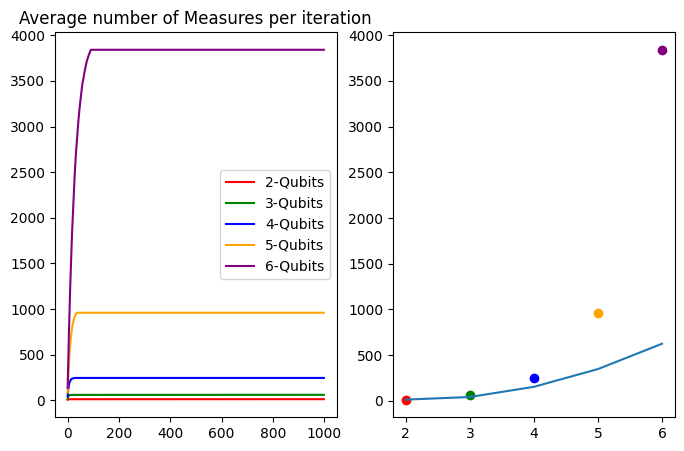

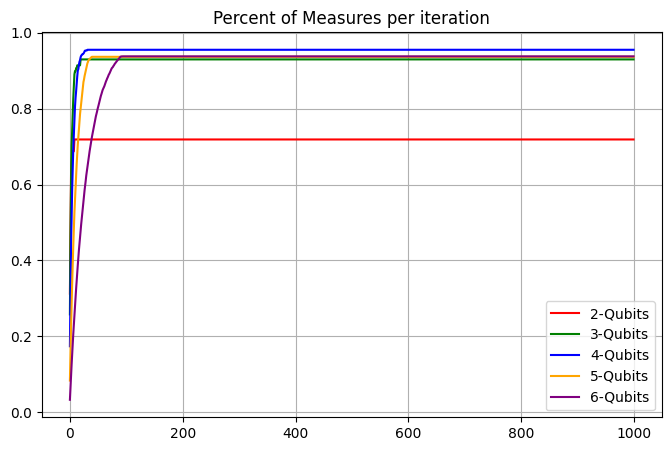

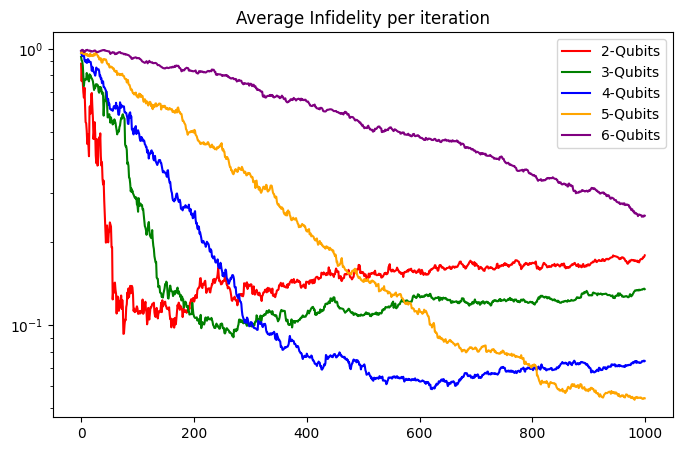

In [13]:
import matplotlib.pyplot as plt

x = NQs 
y = [ meas[4] for meas in Meas ] 
coef = np.polyfit( x, y, 2 )

# Lista de colores arbitrarios
colores = ['r', 'g', 'b', 'orange', 'purple']

# Crear primer conjunto de gráficos para Measures
fig0, ax0 = plt.subplots(1,2, figsize=(8, 5))
ax0[0].set_title('Average number of Measures per iteration')

for j in range(len(NQs)):
    ax0[0].plot(Meas[j], label=f'{NQs[j]}-Qubits', 
                linestyle='-', color=colores[j])
    ax0[1].plot(j+2,Meas[j][-1], 
                'o',
                label=f'{NQs[j]}-Qubits', 
                color=colores[j])
ax0[1].plot( x, np.polyval(coef,x)  ) 

    # ax1.axhline( 4**NQs[j], color=colores[j], linestyle='--' )
ax0[0].legend() 
# Guardar el primer conjunto de gráficos
# fig0.savefig('Measures.png')

# Crear primer conjunto de gráficos para Measures
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title('Percent of Measures per iteration')

for j in range(len(NQs)):
    ax1.plot(Meas[j]/4**NQs[j], label=f'{NQs[j]}-Qubits', 
                linestyle='-', color=colores[j])
    # ax1.axhline( 4**NQs[j], color=colores[j], linestyle='--' )
ax1.grid()
ax1.legend() 
# Guardar el primer conjunto de gráficos
# fig1.savefig('Measures.png')

# Crear segundo conjunto de gráficos para Measures
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.set_title('Average Infidelity per iteration')

for j in range(len(NQs)):
    ax2.semilogy( Fids[j], label=f'{NQs[j]}-Qubits', 
                    linestyle='-', color=colores[j])

ax2.legend()
# Guardar el segundo conjunto de gráficos
# fig2.savefig('Fidelities.png')
    